In [1]:
if "logger" in globals() and  len(logger.handlers) >= 1:
    # To suppress debug output from the logger defined in .ipython/profile_default/ipython_config.py
    logger.handlers.pop()

# Do not autoreload here b/c we need to pickle the ymodel method and it'll
# raise PicklingError: Can't pickle function: it's not the same object
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))
display(HTML("<style>.output_html { display: block; margin-left: auto; margin-right: auto; }</style>"))

# Setup the model, the log likelihood, log prior, and log probability

We want fit the King (1966) model to the data where we believe the quoted 
uncertainties accurately capture the 'true' uncertainties, I guess. The first 
step is to write down the likelihood function (the probability of a dataset
given the model parameters). This is equivalent to describing the generative 
procedure for the data.

[Hogg, Bovy, Lang 2010](https://arxiv.org/pdf/1008.4686.pdf) 
> Imagine that the data *really do* come from the King model, and that the only
> reason that any data point deviates from this perfect, narrow, line  is  that
>  to  each  of  the  true $y$ values  a  small $y$-direction offset has been added,
>  where that offset was drawn from a Gaussian distribution of zero mean and known
>  variance $\sigma_y^2$.  In this model, given an independent position $x_i$, an 
>  uncertainty $\sigma_{yi}$, MLEs $W_0$, $M$, $r_t$, the frequency distribution
> $p(y_i \,| \, x_i, \sigma_{yi}, W_0, M, r_t)$ for $y_i$ is 

(equation 9, but for King model rather than linear fit)

$$
p(y_i \, | \, x_i, \sigma_{yi}, W_0, M, r_t) = \frac{1}{\sqrt{2 \pi \sigma_{yi}^2}}
    \exp \left( - \frac{[y_i - \text{King}(x_i, W_0, M, r_t)]^2}{2 \sigma_{yi}^2} \right)
$$

> which gives the expected frequency (in a hypothetical set of repeated experiments)
> of getting a value in the infinitesimal range $[y_i, y_i+ dy]$ per unit $dy$.
>
> The generative model provides us with a natural, justified, scalar objective: 
> We seek the parameters $W_0, M, r_t$ that maximize the probability of the
> observed data given the model or (in standard parlance) the *likelihood of 
> the  parameters*. In our generative model the data points are independently drawn
> (implicitly), so the likelihood $L$ is the product of conditional probabilities

$$
L = \Pi_{i=0}^N p(y_i \, | \, x_i, \sigma_{yi}, W_0, M, r_t) \quad .
$$ 

Taking the logarithm

$$ \ln L = \Sigma_{i=0}^N  \left[ -\frac{1}{2} \ln(2\pi \sigma_{yi}^2) -
    \frac{ \left[y_i - \text{King}(x_i, W_0, M, r_t) \,\right]^2}{2 \sigma_{yi}^2}  \right] \\
    = K - \frac{1}{2} \chi^2 \\
    = -\frac{1}{2} \Sigma_{i=0}^N  \left[ \frac{ \left[y_i - \text{King}(x_i, W_0, M, r_t) \,\right]^2}{\sigma_{yi}^2} 
        + \ln(2\pi \sigma_{yi}^2) \right]
$$

The last line shows the log likelihood in the [documention](https://emcee.readthedocs.io/en/stable/tutorials/line/#maximum-likelihood-estimation),
and the middle line above shows equation 11 in the paper to make the point that
likelihood maximization is identical to $\chi^2$ minimization.

The Bayesian generalization of this is saying that the the posterior equals 
the data times the prior normalised by the probability marginalised over all
fit parameters.

From the next section of the [documentation](https://emcee.readthedocs.io/en/stable/tutorials/line/#marginalization-uncertainty-estimation):

$$ 
p (W_0, M, r_t\,|\,x,y,\sigma) \propto p(W_0, M, r_t)\,p(y\,|\,x,\sigma, W_0, M, r_t) \quad .
$$

The likelihood function
$$ p(y|x, \sigma , W_0, M, r_t) $$

so the missing component is the "prior" function
$$ p(W_0, M, r_t) $$


In this example, we’ll use uniform (so-called "uninformative") priors on $W_0, M, and r_t$. For example, we'll use the following conservative priors

\begin{split}p(W_0) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 0 < W_0 < 14 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(M) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 2 < \log_{10}(W_0) < 6 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}
    
\begin{split}p(r_t) = \left \{\begin{array}{ll}
        \log_{10}(-\infty)? \,, & \mbox{if}\, 1 < r_t < 300 \\
        0 \,, & \mbox{otherwise}
    \end{array}
    \right .\end{split}

Now the example in the documentation gives
```python
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
```

but this confuses me because it should be 
```python
def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(2*np.pi*sigma2))
```

It should not matter that much, but te $2\pi$ in the normalisation of the Gaussian just disappeared.
I re-added it...


The interested reader should check out [Hogg, Bovy & Lang (2010)](https://arxiv.org/abs/1008.4686) for a much more complete discussion of how to fit a line to data in The Real World™ and why MCMC might come in handy.

# First fit by minimize -log_likelihood

minimise_chisq took 37.25 seconds
Maximum likelihood estimates for minimise_chisq:
  W_0 = 8.565
  M = 107803.317
  r_t = 39.755

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000


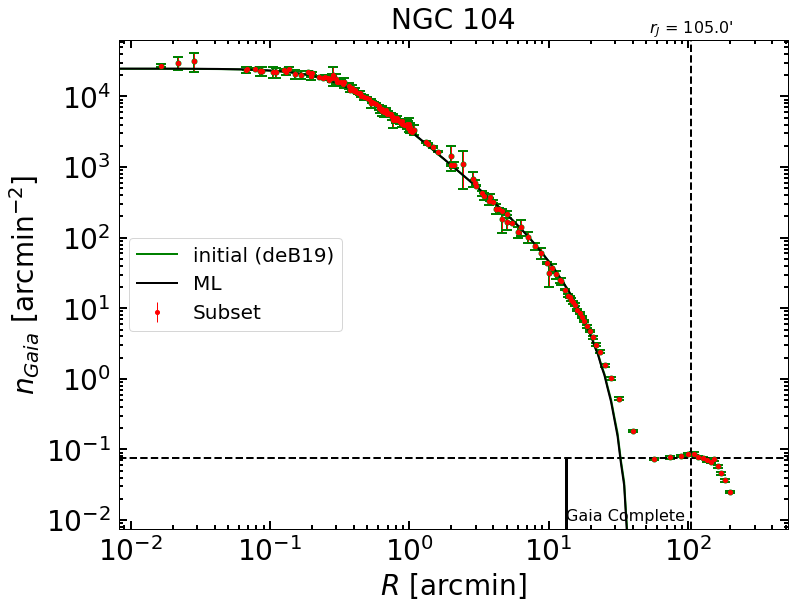

In [3]:
import sys
import numpy
import scipy
import logging
from matplotlib import pyplot

logging.getLogger("keyring").setLevel(logging.CRITICAL)
logging.getLogger("matplotlib").setLevel(logging.CRITICAL)
logging.basicConfig(stream=sys.stdout, format="%(message)s")
logger = logging.getLogger(); logger.level = logging.INFO
for h in logger.handlers: h.setLevel(logger.level)

if "../src" not in sys.path: sys.path.insert(0, "../src")
from tlrh_profiles import (
    limepy_wrapper,
    minimise_chisq,
    run_mcmc,
    inspect_chains,
    get_tau,
    get_flat_samples,
    plot_results,
    plot_corner,
)
from gc_simulation import StarClusterSimulation

if "/supaharris" not in sys.path: sys.path.insert(0, "/supaharris")
from utils import parsec2arcmin

sim = StarClusterSimulation(logger, "NGC 104")
sim.fit_model_to_deBoer2019(mcmc=False, verbose=True)
fig = plot_results(limepy_wrapper, sim, sim.fit_x, sim.fit_y, sim.fit_yerr, 
    initial=sim.initial, ml=sim.soln.x)
pyplot.show(fig)

# Now fit using emcee

In [4]:
sim = StarClusterSimulation(logger, "NGC 104")
sim.fit_model_to_deBoer2019(mcmc=True, Nwalkers=32, Nsamples=500, verbose=True)

minimise_chisq took 36.12 seconds
Maximum likelihood estimates for minimise_chisq:
  W_0 = 8.565
  M = 107803.317
  r_t = 39.755



100%|██████████| 500/500 [14:00<00:00,  1.68s/it]

run_mcmc took 842.68 seconds
The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 10;
tau: [ 34.27314305  45.52567665  36.53570376]
tau: [ 34.27314305  45.52567665  36.53570376]
(3,) float64
discard: 39, thin: 20


# Inspect the chains

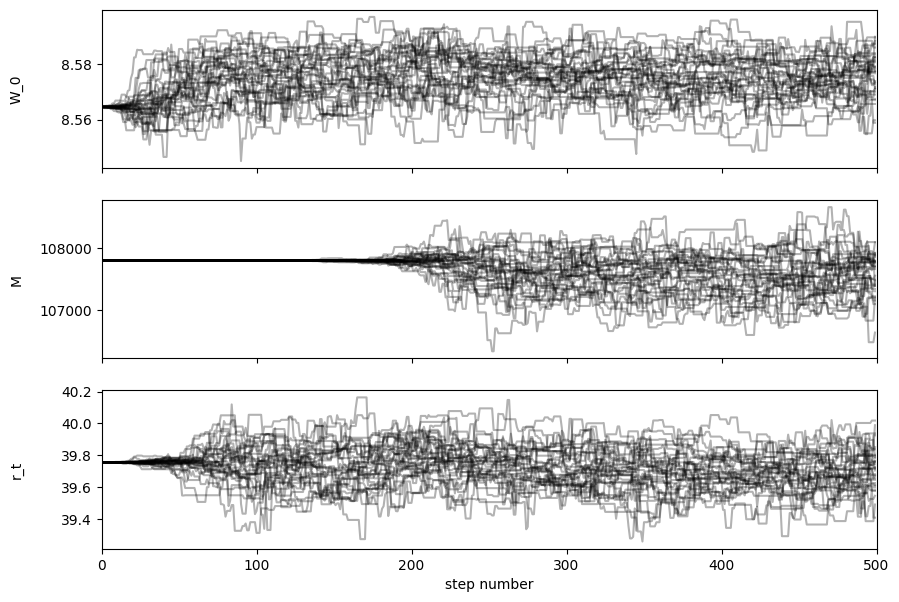

In [5]:
pyplot.style.use("default")
pyplot.show(inspect_chains(sim.sampler, sim.fit_labels))

The walkers start in small distributions around the maximum likelihood values
and then at some point wander and start exploring the full posterior distribution.
This only happens after 200 steps or so for M, so we should discard more samples.

# Inspect the MLEs 

This suggests that only about mean(tau) steps are needed for the chain to ''forget''
where it started. It’s not unreasonable to throw away a few times this number of 
steps as ''burn-in''. Let’s discard the initial 2.5 times mean tau steps, thin by about half
the autocorrelation time, and flatten the chain so that we have a flat list of samples

In [6]:
from tlrh_profiles import get_flat_samples
sim.flat_samples = get_flat_samples(sim.sampler, sim.tau, discard=300, thin=1)

discard: 300, thin: 1


Quantiles:
[(0.16, 8.5674655370067399), (0.5, 8.5753173047398903), (0.84, 8.5826179787232029)]
Quantiles:
[(0.16, 107226.13133604595), (0.5, 107581.50498159054), (0.84, 107903.76283700194)]
Quantiles:
[(0.16, 39.566167644213749), (0.5, 39.691609240900668), (0.84, 39.821665243531044)]


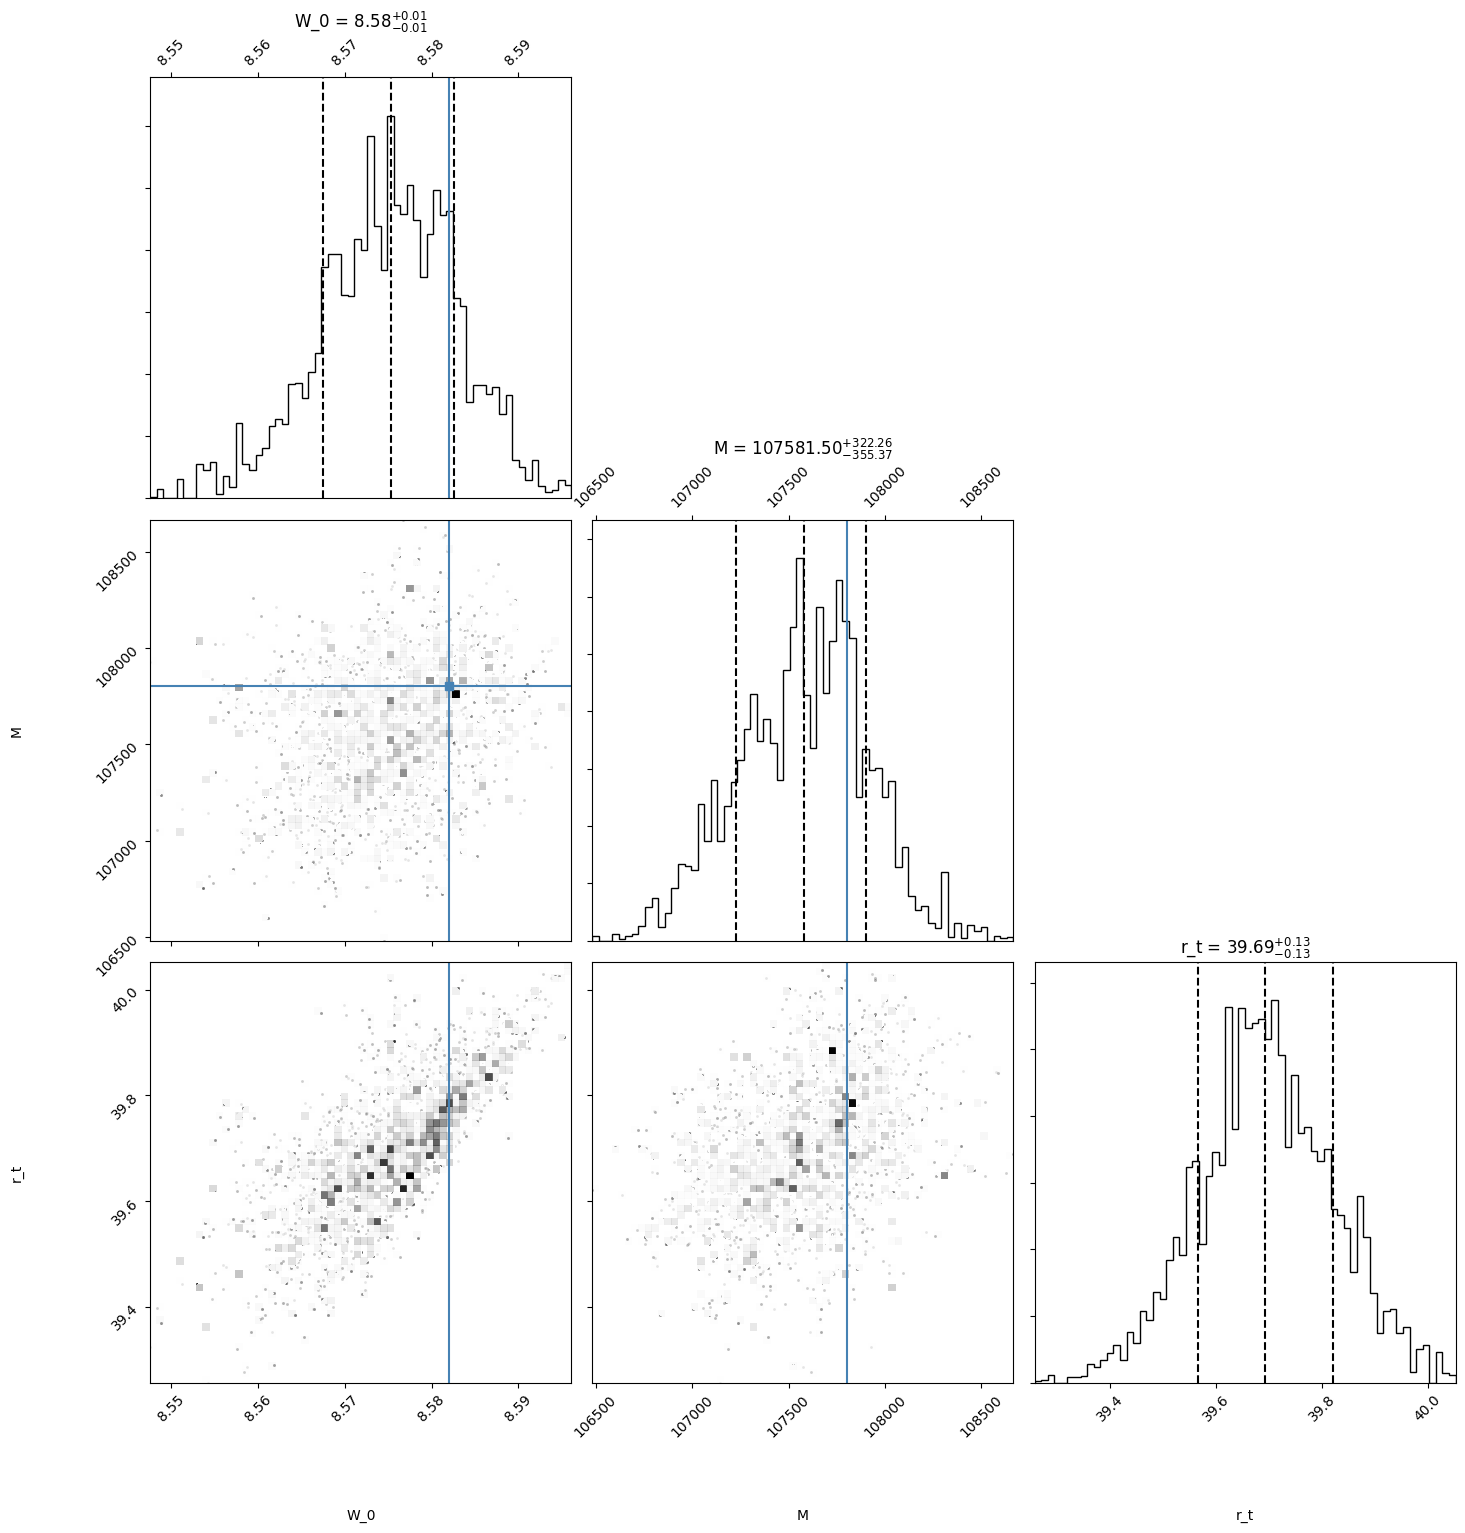

In [8]:
pyplot.style.use("default")
pyplot.show(plot_corner(sim.flat_samples, sim.initial, sim.fit_labels))

Limepy, W0=8.582, M=1.078e+05, rt=40.102, g=1.000
Limepy, W0=8.565, M=1.078e+05, rt=39.755, g=1.000
Limepy, W0=8.576, M=1.078e+05, rt=39.725, g=1.000


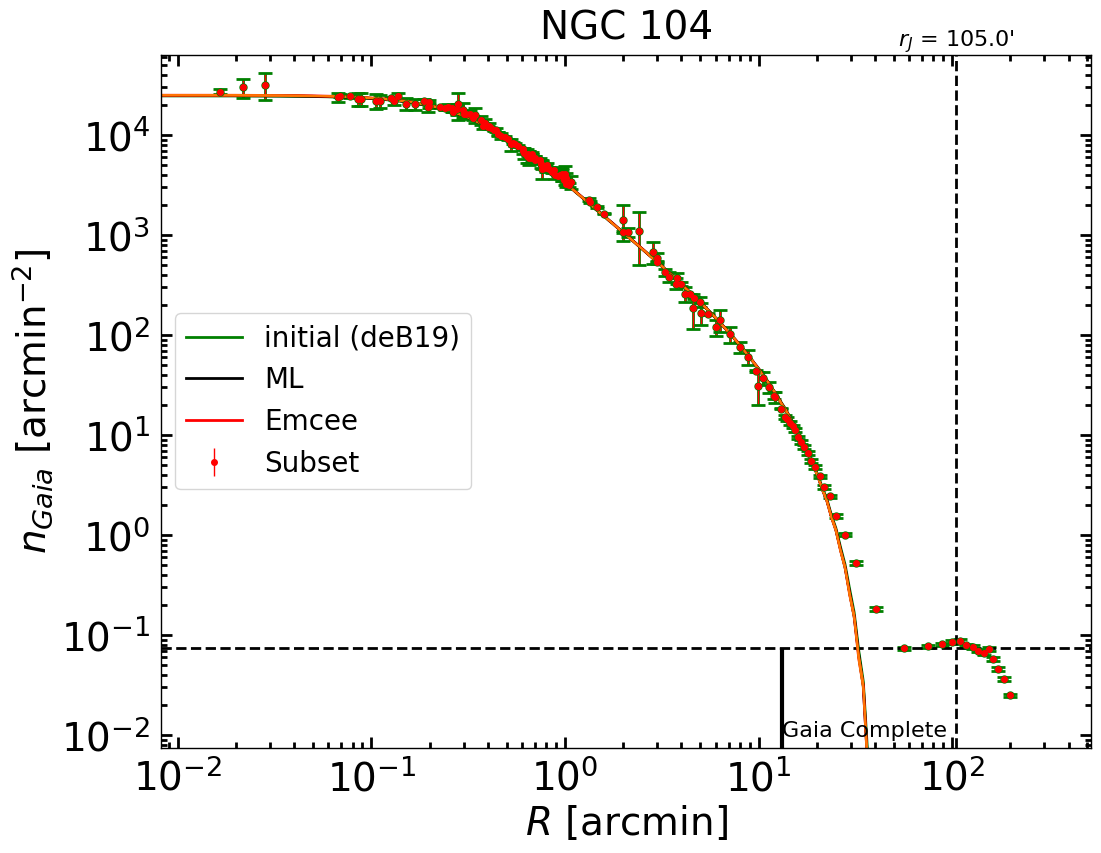

In [9]:
pyplot.style.use("tlrh")
pyplot.show(plot_results(limepy_wrapper, sim, sim.fit_x, sim.fit_y, sim.fit_yerr, 
    initial=sim.initial, ml=sim.soln.x, mcmc=sim.mcmc_mle, flat_samples=sim.flat_samples)
)